<a href="https://colab.research.google.com/github/antocommi/provagcp/blob/master/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install -q -U albumentations 

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 952kB 46.4MB/s 


In [67]:
SEED = 9126

import os, cv2, json, time, math, sys, pickle, collections, PIL
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
import seaborn as sn

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

#from google.colab import drive
#drive.mount('/content/drive')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
if CUDA:
    print('run on %s' % device)

In [3]:
# Download and load in memory dataset from kaggle
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"antocommii","key":"87dcebd7c4cb4ba4539ed72f027fcbde"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!kaggle datasets download --unzip --force antocommii/spacejam-action-recognition -p /content/kaggle/

# abbiamo 10 classi
num_classes = 10

# il dataset è ciò che si ottiene dal metodo precedente
ROOT_DIR = "/content/kaggle/"
VIDEO_DIR = "/content/kaggle/examples/"
ANNOTATION_FILE = "annotation_dict.json"
TEST_SET_FILE = "testset_keys_1lug2020.txt"

# prendo il dataset da annotation file
with open(os.path.join(ROOT_DIR, ANNOTATION_FILE)) as fp:
  annotations = json.load(fp)
            
with open(os.path.join(ROOT_DIR, TEST_SET_FILE)) as fp:
  keys_test = json.load(fp)

# divido in train e test second quello che ho nel file
annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))
test_set = list(annotationTest.items())

# divido in train e validation
test_size = 0.2
train_set, valid_set = train_test_split(list(annotationTrain.items()), random_state=456, test_size=test_size, stratify=list(annotationTrain.values()))

100% 624M/626M [00:06<00:00, 107MB/s] 
100% 626M/626M [00:06<00:00, 106MB/s]


In [80]:
class CustomSet(torch.utils.data.Dataset):
    def __init__(self, videos_dir, list_dataset, transform):
        """ Construct an indexed list of video paths and labels """
        self.transform = transform
        self.VIDEO_DIR = videos_dir
        self.dataset = list_dataset
        mean = [0.485,0.456,0.406]
        std = [0.229,0.224,0.225]
        self.toTensor = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, std)
        ])

    def __getitem__(self, index, is_for_testing=True):
        """ Load video n in the list of image paths and return it along with its label.
            In the case of multiclass the label will probably be a list of values"""
        
        name, label = self.dataset[index]
        
        fname = os.path.join(self.VIDEO_DIR, name+'.mp4')
        
        video = []
        vid = cv2.VideoCapture(fname)
        while True:
            # Capture frame-by-frame
            ret, frame = vid.read()
            if ret != True:
              break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(image=np.array(frame))['image']
            frame = self.toTensor(Image.fromarray(frame))
            video.append(frame)

        video = torch.stack(video)
        video = torch.transpose(video, 1, 0)
        return {'video':video, 'label':torch.LongTensor([label])}
        

    def __len__(self):
        """ return the total number of video in this dataset """
        return len(self.dataset)

    def get_list(self):
      return self.dataset

In [106]:
crop_H, crop_W = 176,60
new_H, new_W = 224,224
print("New Size: ",new_H,new_W)
print("Crop Size: ",176, 80)

A_train = A.Compose([
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                     A.augmentations.Resize(new_H, new_W, interpolation=4, p=1),
                     A.augmentations.transforms.CLAHE(clip_limit=4.0, p=1)
                     #A.augmentations.transforms.FancyPCA(alpha=.5, p=1)
                     ])

A_test = A.Compose([
                     A.augmentations.transforms.CenterCrop(crop_H, crop_W, p=1),
                     #A.augmentations.Resize(new_H, new_W, interpolation=4, p=1)
                     ])


# trasformo in custom_dataset
train_ds = CustomSet(VIDEO_DIR, train_set, A_train)
valid_ds = CustomSet(VIDEO_DIR, valid_set, A_test)
test_ds = CustomSet(VIDEO_DIR, test_set, A_test)

# definisco le batch_size
BATCH_TRAIN_SIZE, BATCH_TEST_SIZE = 16,16

# creo i dataloader
trainLoader = DataLoader(train_ds, batch_size=BATCH_TRAIN_SIZE, shuffle=True)
validLoader = DataLoader(valid_ds, batch_size=BATCH_TEST_SIZE, shuffle=True)
testLoader = DataLoader(test_ds, batch_size=BATCH_TEST_SIZE, shuffle=True)

# controllo se hanno la stessa forma di lista di tuple
print(len(trainLoader), len(validLoader), len(testLoader))
print(train_set[0])

New Size:  224 224
Crop Size:  176 80
1298 325 696
('0011804', 9)


ball in hand


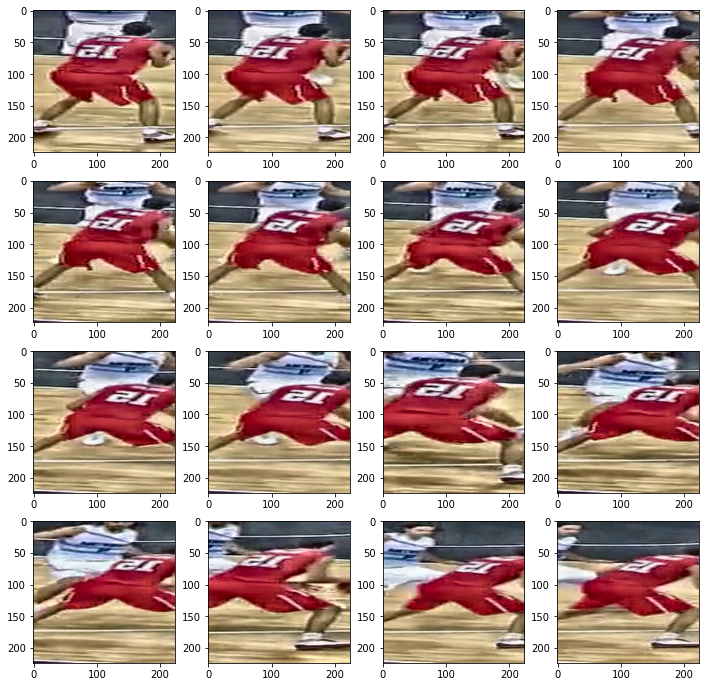

In [108]:
labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}

for item in trainLoader:
  video = item['video'][0]
  label = item['label'][0]
  break
clip = torch.transpose(video, 0, 1)

print(labels_dict[label.item()])
plt.figure(figsize=(12, 12))
for i in range(clip.shape[0]):
  plt.subplot(4,4, i+1)
  video = clip[i]
  trans = transforms.ToPILImage(mode="RGB")
  video = trans(video)
  plt.imshow(video)
plt.show()